<a href="https://colab.research.google.com/github/rotom303/Final_Project/blob/Alexander/Final_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BE 521: Final Project Part 1
Collaborators: Aakash Jajoo, Chaoyi Cheng

Spring 2023

Adapted by Kevin Xie

32 Points

Objective: Predict finger movements from ECoG Recordings

Due: March 31st


# Project Overview

This final project involves predicting finger flexion using intracranial EEG (ECoG) in three human subjects. The data and problem framing come from the 4th BCI Competition (Miller et al. 2008). For the details of the problem, experimental protocol, data, and evaluation, please see the original 4th BCI Competition documentation (included as separate document). The remainder of the current document details your deliverables for part 1 of the project.


## Important Deadlines
* Final Project Part 1
 * Due: March 31st
 * 32 Points
* Team Registration
 * Due: March 31st
 * 5 Points
* Checkpoint 1
 * Due: April 14th
 * 20 Points
* Checkpoint 2
 * Due: April 21st
 * 15 Points
* End of competition, submit algorithm (Canvas): 
 * Due: April 25th
 * 15 Points
* Final Report
 * Due: April 28th
 * 60 Points
* Competition results (Final class session)
 * On: April 27th

The grading is structured so that going the extra mile is definitely rewarded. We want you to show what you've learned this semester, and to have some fun!

# 1. Setup
Imports necessary libraries and reads the data from files.

In [ ]:
#Set up the notebook environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.io import loadmat


import random
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Brain_Computer_Interfaces/Final_Project/

Mounted at /content/drive
/content/drive/MyDrive/Brain_Computer_Interfaces/Final_Project


In [ ]:
#with open('final_proj_part1_data.pkl', 'rb') as f:
#  proj_data = pickle.load(f)
proj_data = loadmat('raw_training_data.mat')
leaderboard_data = loadmat('leaderboard_data.mat')

In [ ]:
raw_ecog = proj_data['train_ecog'][:,0]
raw_glove = proj_data['train_dg'][:,0]


In [ ]:
m = len(proj_data['train_ecog'][0,0][:,0]) # Number of samples per channel
trn_m = int(m *2/3)
tst_m = int(m/3)
print(f'There are {m} samples per channel for each ECoG and Data Glove recording.')
print(f'The first {trn_m} samples in each channel will be the traing data.')
print(f'The remaining {tst_m} samples in each channel will be for validation.\n')
training = []
testing = []
trainingGlove = []
testingGlove = []
for i in range(3):
  total = len(proj_data['train_ecog'][i,0].flatten())
  training.append(proj_data['train_ecog'][i,0][0:trn_m,:])
  testing.append(proj_data['train_ecog'][i,0][trn_m:m,:])
  print(f'In subject {i+1}, \nTotal ECoG samples = {total}')
  print(f'Training ECoG samples = {len(training[i].flatten())}')
  print(f'Testing ECoG samples = {len(testing[i].flatten())}')
  total = len(proj_data['train_dg'][i,0].flatten())
  trainingGlove.append(proj_data['train_dg'][i,0][0:trn_m,:])
  testingGlove.append(proj_data['train_dg'][i,0][trn_m:m,:])
  print(f'Total Glove samples = {total}')
  print(f'Training Glove samples = {len(trainingGlove[i].flatten())}')
  print(f'Testing Glove samples = {len(testingGlove[i].flatten())}')
  print('')

There are 300000 samples per channel for each ECoG and Data Glove recording.
The first 200000 samples in each channel will be the traing data.
The remaining 100000 samples in each channel will be for validation.

In subject 1, 
Total ECoG samples = 18600000
Training ECoG samples = 12400000
Testing ECoG samples = 6200000
Total Glove samples = 1500000
Training Glove samples = 1000000
Testing Glove samples = 500000

In subject 2, 
Total ECoG samples = 14400000
Training ECoG samples = 9600000
Testing ECoG samples = 4800000
Total Glove samples = 1500000
Training Glove samples = 1000000
Testing Glove samples = 500000

In subject 3, 
Total ECoG samples = 19200000
Training ECoG samples = 12800000
Testing ECoG samples = 6400000
Total Glove samples = 1500000
Training Glove samples = 1000000
Testing Glove samples = 500000



# 2. Filter Design
This is where the filter is designed for the ECoG data. 

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


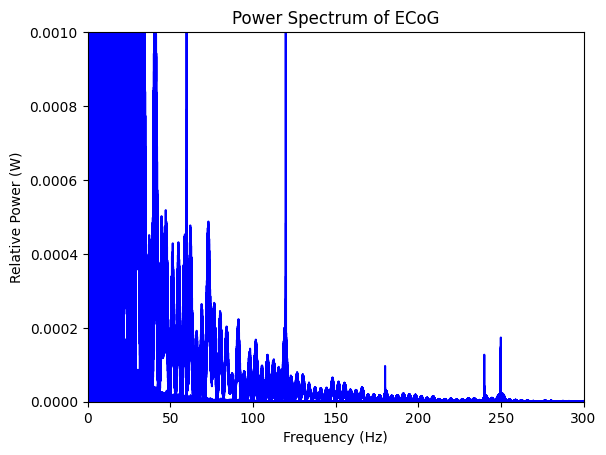

In [ ]:
from scipy.fft import fft, fftfreq
# Code to identify the best filter 
fs = 1000
for i in range(len(training[0][0,:])):
  signal = training[0][:,i]
  f = fftfreq(len(signal),1/fs) # Create frequency domain for x axis
  freq_response = fft(signal) # take the fft of ep signal
  power = freq_response* np.conj(freq_response)/len(f) # calculate power spectrum of fft. 
  plt.plot(f,power*1e-12,'b') # 1e-12 is unit conversion from pW to W
  #plt.plot(f,freq_response*1e-6)
plt.xlim(0,300);plt.ylim(0,0.001)
plt.title('Power Spectrum of ECoG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Power (W)');

There appears to be an artifact at 60Hz and its harmonics from the power supply. There is also a lot of low frequency signal content. I'll use a notch pass filter to remove these. 
Strangely, there is a lot of frequency content at 250Hz, I do not know what it is. 

The Kubanek 2009 paper suggests that frequencies above 50Hz are reltaed to hand movement. Specifically, the high gamma waves (75-115Hz) are most related to finger movement. For now, I'll focus on that, but its possible that some of these lower frequencies or the 250Hz spike may be relevant for improving prediction accuracy later.  

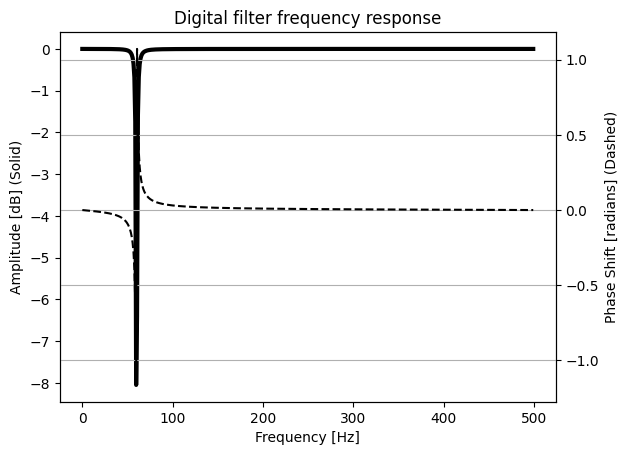

In [ ]:
Q = 30
b, a = sig.iirnotch(60,Q,fs=fs); c = 'k'
w, h = sig.freqz(b, a, fs=fs); 
fig, ax1 = plt.subplots();
ax1.set_title('Digital filter frequency response')
ax1.set_ylabel('Amplitude [dB] (Solid)'); ax1.set_xlabel('Frequency [Hz]')
ax1.plot(w, 20 * np.log10(abs(h)), color=c,linewidth=3)
ax2 = ax1.twinx(); ax2.set_ylabel('Phase Shift [radians] (Dashed)')
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, color=c,linestyle = 'dashed')
ax2.grid(True); ax2.axis('tight'); plt.show()

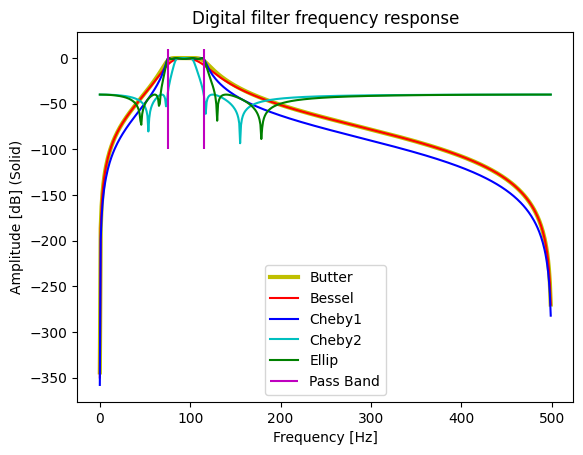

In [ ]:
# Testing Different Filters
global fc;
fc = [0.5,115]
order = 4; rp = 1; rs = 40; bandtype = "band"

fig, ax1 = plt.subplots();
ax1.set_title('Digital filter frequency response')
ax1.set_ylabel('Amplitude [dB] (Solid)'); ax1.set_xlabel('Frequency [Hz]')
#ax2 = ax1.twinx(); ax2.set_ylabel('Phase Shift [radians] (Dashed)')

b, a = sig.butter(order,fc,btype="band",fs=fs)
w, h = sig.freqz(b, a, fs=fs); angles = np.unwrap(np.angle(h))
c = 'y';ax1.plot(w, 20 * np.log10(abs(h)), color=c,linewidth=3)
#ax2.plot(w, angles, color=c,linestyle = 'dashed')

b, a = sig.bessel(order,fc,btype=bandtype,fs=fs)
w, h = sig.freqz(b, a, fs=fs); angles = np.unwrap(np.angle(h))
c = 'r';ax1.plot(w, 20 * np.log10(abs(h)), color=c)
#ax2.plot(w, angles, color=c,linestyle = 'dashed')

b, a = sig.cheby1(order,rp,fc,btype=bandtype,fs=fs)
w, h = sig.freqz(b, a, fs=fs); angles = np.unwrap(np.angle(h))
c = 'b';ax1.plot(w, 20 * np.log10(abs(h)), color=c)
#ax2.plot(w, angles, color=c,linestyle = 'dashed')

b, a = sig.cheby2(order,rs,fc,btype=bandtype,fs=fs)
w, h = sig.freqz(b, a, fs=fs); angles = np.unwrap(np.angle(h))
c = 'c';ax1.plot(w, 20 * np.log10(abs(h)), color=c)
#ax2.plot(w, angles, color=c,linestyle = 'dashed')

b, a = sig.ellip(order,rp,rs,fc,btype=bandtype,fs=fs)
w, h = sig.freqz(b, a, fs=fs); angles = np.unwrap(np.angle(h))
c = 'g';ax1.plot(w, 20 * np.log10(abs(h)), color=c)
#ax2.plot(w, angles, color=c,linestyle = 'dashed')

ax1.vlines(fc,-100,10,'m')
ax1.legend(["Butter","Bessel","Cheby1","Cheby2","Ellip","Pass Band"])
#ax2.grid(True); ax2.axis('tight'); 
plt.show()

The Butter, Cheby1, and Ellip filters all have good passbands, but I only want to use one of them. Ellip can produce ripples on the passband sometime, so it won't be that. Cheby1 seems to have the most consistent passband with better attenuation than Butter.

In [ ]:
def filter_artifact(raw_eeg,fs=1000,Q=50):
  """
    Removes Power artifact. defined filter_data to remove clutter.
  """
  Q = 50 # Quality factor of notch band
  b, a = sig.iirnotch(60,Q,fs=fs)
  filtered_data = sig.filtfilt(b,a,raw_eeg)
  b, a = sig.iirnotch(120,Q,fs=fs)
  filtered_data = sig.filtfilt(b,a,filtered_data)
  return filtered_data

def filter_data(raw_eeg, fs=1000,fc=[75,115]):
  """
  Write a filter function to clean underlying data.
  Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
  Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
  distorting the underlying data!

  Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
  Output: 
    clean_data (samples x channels): the filtered signal
  """
  # a Notch filter at 60Hz since that is an artifact from power supply. And its resonant frequencies too
  # a Low pass filter for 10 Hz since most of signal is under 10Hz, but may not be relvant.
  # Subject 1 & 3 have something at 7.5Hz (1 has more).
  # There is already no DC signal for any subject. 
  # Kubanek 2009 paper indicates that high gamma [75-115]Hz are most relevant for finger movement.
  
  number_of_channels = np.shape(raw_eeg)[1] #number of channels
  filteredData = np.zeros(np.shape(raw_eeg)); #filtered data output

  #cheby1 filter of 5th order
  sos = sig.cheby1(5, 1, fc, 'bandpass', analog=False, fs=fs, output='sos'); # returns filter coefficients

  #for each channel
  for chanInd in np.arange(number_of_channels):
    # subtract mean from each datapoint
    currFilt = raw_eeg[:, chanInd] - np.mean(raw_eeg[:, chanInd]);
    currFilt = filter_artifact(currFilt)
    #currFilt = sig.sosfiltfilt(sos, currFilt) # forward-backward digital filter using cascaded second-order sections                                        
    filteredData[:, chanInd] = currFilt
  return filteredData

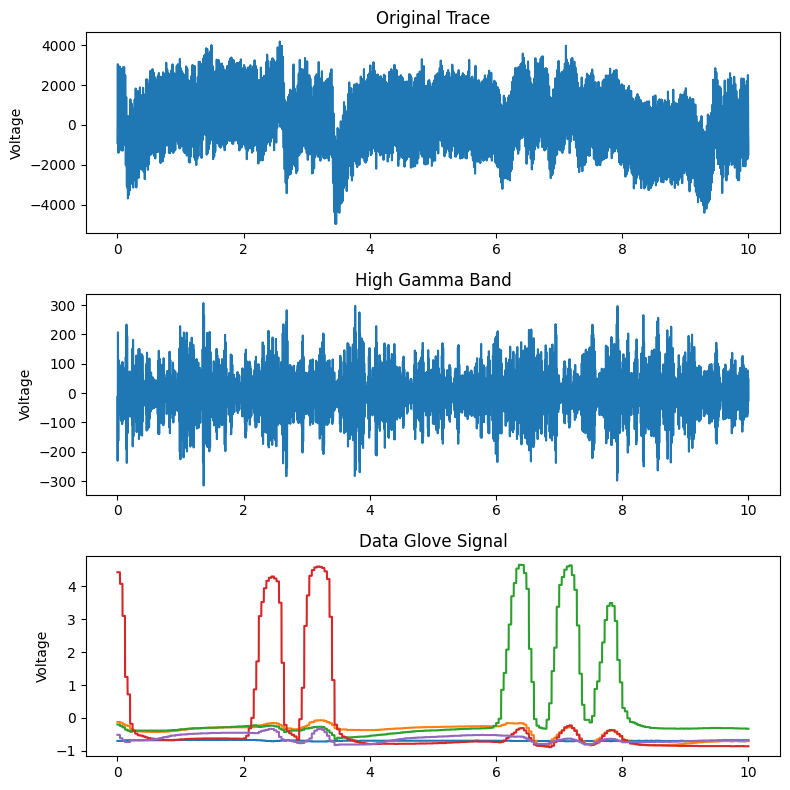

In [ ]:
plt.figure(figsize=(8, 8))
#time stamps
start = 0;end = 10000
snapshot = training[1][start:end, 20]
times = np.linspace(start/fs, end/fs, len(snapshot))
#plot original trace
plt.subplot(3, 1, 1)
plt.plot(times, training[1][start:end, 20])
plt.title('Original Trace')
plt.ylabel('Voltage');

#plot high gamma filt
plt.subplot(3, 1, 2)
plt.plot(times, filter_data(training[1][start:end, :],fs,fc)[:, 5])
plt.title('High Gamma Band')
plt.ylabel('Voltage');

plt.subplot(3, 1, 3)
plt.plot(times, trainingGlove[1][start:end, :])
plt.title('Data Glove Signal')
plt.ylabel('Voltage');

plt.tight_layout()

# 3. Defining Features and Feature Extraction

Here the features that we could extract and analyze from the ECoG will be defined. We wil ldefine which we use in a later section. The windowing method is also defined here. 

## 1. 
We will calculate features across sliding time windows. if we use a suggested window length of 100ms with a 50ms window overlap, how many feature windows, $M$, will we have if we computed features using all the data in a given subject? Feel free to re-use code from previous homeworks. 

In [ ]:
def NumWins(x,winLen,winDisp,fs=1000):
  """
    Calculates the number of possible full windows that can fit in x
    Inputs:
      x is the signal in the time domain. 
      fs is the sampling frequency of x. Hz.
      winLen is the length of windows. sec
      winDisp is the displacement between the start of each window. sec
  """
  x_duration = len(x)/fs # seconds.
  windows_fit = (x_duration - winLen + winDisp) / (winDisp)
  # default behaviour of int() is to floor float, so using round()
  return round(windows_fit)

x = training[0][:,0] 
fs=1000
winLen=100e-3
winDisp=50e-3

num_windows=NumWins(x,winLen,winDisp,fs)
print(f'The number of windows, M = {num_windows}')

The number of windows, M = 3999


## 2.
Now complete the `get_features` function. Please create **4 or more** different features to calculate for each channel in each time window. Features may include the average time-domain voltage, or the average frequency-domain magnitude in consecutive 15Hz frequency bands, bandpower of relevant frequency bands, etc...

In [ ]:
global featFns;
featFns = [] # A list that stores all the Feature Objects used
# The following are just booleans to make code clearer
uses_raw = True; uses_filtered = False 
normalized = True; not_normalized = False

class Feature():
  def __init__(self,useRaw=False, doNormalize=True):
    self.useRaw = useRaw # Whether or not the feature is extracted from the raw or filtered data.
    self.doNormalize = doNormalize # Whether or not to normalize this feature
    self.mean = 0 # mean
    self.std = 1 # standard deviation
    featFns.append(self)

  def __call__(self, signal_data):
    return signal_data

  def standardize_training(self,training_feat):
    if(self.doNormalize):
      self.mean = np.mean(training_feat)
      self.std = np.std(training_feat)
    return (training_feat - self.mean)/self.std

  def standardize_testing(self,testing_feat):
    return (testing_feat-self.mean) / self.std
  
class LineLength(Feature):
  def __call__(self,x):
    return np.sum(np.absolute(np.ediff1d(x)))

class Area(Feature):
  def __call__(self,x):
    return np.sum(np.absolute(x))

class Energy(Feature):
  def __call__(self,x):
    return np.sum(np.square(x))

class ZeroCrossings(Feature):
  def __call__(self,x):
    return np.size(np.nonzero(np.ediff1d(np.sign(x-np.mean(x)))))

class Mean(Feature):
  def __call__(self,x):
    return np.mean(x)

class FreqBand(Feature):
  def __init__(self,f_low,f_high,useRaw=True,doNormalize=True):
    Feature.__init__(self,useRaw,doNormalize)
    self.useRaw = useRaw
    self.f_low = f_low
    self.f_high = f_high
  def __call__(self,x):    
    freq_response = fft(signal)
    N = len(freq_response)
    n = np.arange(N)
    T = N/fs #sampling rate=1000
    freq = n/T 
    power_spectrum = np.abs(freq_response)
    # Find values in frequency vector corresponding to input band
    index_band = np.logical_and(freq >= self.f_low, freq <= self.f_high)
    #average frequency domain magnitude
    avg_mag = np.mean(power_spectrum[index_band])
    return avg_mag


line_length = LineLength(uses_filtered,normalized)
area = Area(uses_filtered,normalized)
energy = Energy(uses_filtered,normalized)
zero_crossings = ZeroCrossings(uses_filtered,normalized)
mean = Mean(uses_filtered,normalized)
freq_band_5_to_15 = FreqBand(5,15,uses_raw,normalized)
freq_band_20_to_25 = FreqBand(20,25,uses_raw,normalized)
freq_band_75_to_115 = FreqBand(75,115,uses_raw,normalized)
freq_band_125_to_160 = FreqBand(125,160,uses_raw,normalized)
freq_band_160_to_175 = FreqBand(160,175,uses_raw,normalized)



In [ ]:
def get_features(raw_window,filtered_window, fs=1000):
  """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!

    Input: 
      window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate

    Global Inputs: must be defined outside of the function
      featFns: a list containing the methods to apply as feats. 
    
    Output:s
      features (channels x num_features): the features calculated on each channel for the window
  """
  [window_samples,num_channels]=np.shape(raw_window)
  features=np.empty((num_channels,len(featFns)))
  i = 0
  for feat in featFns:
    if feat.useRaw: window = raw_window
    else: window = filtered_window
    for chn in range(num_channels):
      current_window = window[:,chn]
      features[chn,i] = feat(current_window)
    i+=1
  return features

In [ ]:
def get_windowed_feats(ecog_data, fs, window_length, window_overlap):
  """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      glove_data 
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap

    Global Inputs: must be defined outside of the function
      noFilter: a Boolean to get unfiltered windows
      fc: The filter passband frequencies
      featFns: a list containing the methods to apply as feats. 

    Output: 
      all_feats (num_windows x (channels x features)): the features for each channel for each time window
        note that this is a 2D array. 
  """
  [num_samples,num_channels]=np.shape(ecog_data)
  num_windows = NumWins(ecog_data, window_length,window_overlap, fs) 
  filtered_ecog = apply_filter(ecog_data)
  #convert everything to units of samples
  wLen=round(window_length*fs) #window length in samples
  wDisp=round(window_overlap*fs) #window displacement in samples
  data_feats = np.zeros((num_windows,num_channels*len(featFns))); # stores the features of the window
  
  rightmost = num_samples
  for i in range(num_windows):
    raw_window = ecog_data[rightmost-wLen:rightmost,:]
    filtered_window = filtered_ecog[rightmost-wLen:rightmost,:]
    data_feats[-1-i,:] = (get_features(raw_window,filtered_window).flatten())
    rightmost = rightmost - wDisp
  return data_feats


In [ ]:
def standardize_training(feature_matrix):
  [windows_trn,feats_trn] = np.shape(feature_matrix)
  normFeats = np.empty((windows_trn,feats_trn))
  for i in range(feats_trn):
      normFeats[:,i] = featFns[i].standardize_training(feature_matrix)
  return normFeats

def standardize_testing(feature_matrix):
  [windows_trn,feats_trn] = np.shape(feature_matrix)
  normFeats = np.empty((windows_trn,feats_trn))
  for i in range(feats_trn):
      normFeats[:,i] = featFns[i].standardize_testing(feature_matrix)
  return normFeats

def standardize_both(train_feats, test_feats):
  return standardize_training(train_feats), standardize_testing(test_feats)

# 4. Training Parameters
Here we will use the optimal linear decoder framework to predict finger angles, and additionally you will use one or more classifiers of your own choosing to make the prediction.

In [ ]:
def startpoint_downsample(finger_window):
  return finger_window[0]

def endpoint_downsample(finger_window):
  return finger_window[-1]

def max_downsample(finger_window):
  return np.max(finger_window)

def area_downsample(finger_window):
  return np.sum(np.absolute(finger_window))

def downsample_glove(glove_window,downsample_method = max_downsample):
  [num_samples,num_channels] = np.shape(glove_window)
  downsampled_glove = np.empty(num_channels)
  for chn in range(num_channels):
    current_window = glove_window[:,chn]
    downsampled_glove[chn] = downsample_method(current_window)
  return downsampled_glove

def get_finger_windows(glove_data,winLen=100e-3,winDisp=50e-3,fs=1000):
  """
    Creates an array where each for window labels where the label is whichever finger has
    the highest finger angle in the window. 
  """
  [num_samples,num_channels]=np.shape(glove_data)
  num_windows = NumWins(glove_data, winLen,winDisp, fs)
  wLen=round(winLen*fs) #window length in samples
  wDisp=round(winDisp*fs) #window displacement in samples
  windowed_fingers = np.zeros((num_windows,num_channels)); # stores the features of the window
  rightmost = num_samples
  for i in range(num_windows):
    window = glove_data[rightmost-wLen:rightmost,:]
    windowed_fingers[-1-i,:] = (downsample_glove(window).flatten())
    rightmost = rightmost - wDisp
  return windowed_fingers

def compare_downsample_methods(glove_data,method1,method2,winLen=100e-3,winDisp=50e-3,fs=1000):
  [num_samples,num_channels]=np.shape(glove_data)
  num_windows = NumWins(glove_data, winLen,winDisp, fs)
  wLen=round(winLen*fs) #window length in samples
  wDisp=round(winDisp*fs) #window displacement in samples
  windowed_fingers1 = np.zeros((num_windows,num_channels)); # stores the features of the window
  windowed_fingers2 = np.zeros((num_windows,num_channels)); # stores the features of the window
  rightmost = num_samples
  for i in range(num_windows):
    window = glove_data[rightmost-wLen:rightmost,:]
    windowed_fingers1[-1-i,:] = (downsample_glove(window,method1).flatten())
    windowed_fingers2[-1-i,:] = (downsample_glove(window,method2).flatten())
    rightmost = rightmost - wDisp
  compared = np.argmax(windowed_fingers1,axis=1)-np.argmax(windowed_fingers2,axis=1)
  differences = np.nonzero(compared)[0]
  print(f'The methods {method1} and {method2} label the fingers differently in {len(differences)} windows')
  return differences


In [ ]:
# Compare Different Labelling mechanisms
remove4 = True; patient=0
if remove4:
  glove_data = raw_glove[patient][:,[0,1,2,4]]
else:
  glove_data = raw_glove[patient]



3290


In [ ]:
winLen = 100e-3; winDisp = 50e-3; N_wind = 3
fc = [75,115]; 

trn_feats = []; trn_labels=[];
tst_feats = []; tst_labels=[];
linear_filters = []
trn_f_predict = []; tst_f_predict = []


for i in range(round(M)): #for each window
  Y_train_p1[i,:]=training_p1_glove[window_start,:] #find the flexion data for each finger at that window from glove data for P1
  window_start=window_start+winDisp_samples #move to next window

for p in range(3):
  trn_labels.append(get_finger_windows(trainingGlove[p]))
  tst_labels.append(get_finger_windows(testingGlove[p]))
  
  trn_feats.append(get_windowed_feats(training[p],fs,winLen,winDisp))
  tst_feats.append(get_windowed_feats(testing[p],fs,winLen,winDisp))

    normed_trn, normed_tst = standardize_train_test(trn_feats[p],tst_feats[p])
    trn_feats[p]=normed_trn; tst_feats[p]=normed_tst

  linear_filters.append(optimized_linear_filter(trn_feats[p],trn_labels[p]))
  trn_f_predict.append(apply_linear_filter(linear_filters[p],trn_feats[p]))
  tst_f_predict.append(apply_linear_filter(linear_filters[p],tst_feats[p]))

NameError: ignored

In [ ]:
def optimized_linear_filter(feat_windows,label_vector,N_wind=3):
  """
    Reconstructs the labels. 
  """
  R = create_R_matrix(feat_windows, 3)
  Rt = R.transpose()
  f = np.matmul(np.linalg.inv(np.matmul(Rt,R)),np.matmul(Rt,label_vector))
  return f

def apply_linear_filter(linear_filter,feat_windows):
  R = create_R_matrix(feat_windows, N_wind)
  return np.round(np.matmul(R,linear_filter))

def standardize_train_test(feature_matrix,test_feature_matrix):

  [windows_trn,feats_trn] = np.shape(feature_matrix)
  [windows_tst,feats_tst]=np.shape(test_feature_matrix)
  normFeatsTrn=np.empty((windows_trn,feats_trn))
  normFeatsTst=np.empty((windows_tst,feats_tst))

  for i in range(feats_trn):
      curr_train = feature_matrix[:,i]
      mean_train=np.mean(curr_train)
      std_train=np.std(curr_train)
      normFeatsTrn[:,i]=(curr_train-mean_train)/std_train
      curr_test = test_feature_matrix[:,i]
      normFeatsTst[:,i]=(curr_test-mean_train)/std_train #normalize test features using training mean/std
  return normFeatsTrn,normFeatsTst


## 2.
Try one other machine learning classifier using your features and finger angle labels. Look back through previous homeworks to get some ideas

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def fit_model(model):
  featFns = [line_length, area, energy, zero_crossings]
  fc = [75,115]; noFilter = False
  output = []
  for i in range(3):
    output.append(sklearn.base.clone(model))
    output[i].fit(trn_feats[i],np.argmax(trn_labels[i],axis=1))
  return output


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Generate synthetic data for brain signals and finger flexion measurements
# Replace this with actual data from your experiment
brain_signals = np.random.randn(100, 10)  # 100 samples, 10 features
finger_flexion = np.random.randint(0, 2, 100)  # Binary labels (0 or 1) for finger flexion

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training, trainingGlove, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC(kernel='linear', C=1.0)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Predict the finger flexion labels for the test data
y_pred = svm.predict(X_test)

# Calculate accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

From chat GTP:

This code uses the numpy library to generate synthetic data for brain signals and finger flexion measurements. It then uses the train_test_split function from sklearn to split the data into training and testing sets. Next, it creates an SVM classifier using the SVC class from sklearn.svm, with a linear kernel and regularization parameter C set to 1.0. The classifier is then trained on the training data using the fit method. Finally, it predicts the finger flexion labels for the test data using the predict method and calculates the accuracy of the classifier using the accuracy_score function from sklearn.metrics. Note that this is a basic example and may not be suitable for real-world data. You may need to further preprocess the data, tune hyperparameters, and perform additional evaluations depending on your specific use case. Also, keep in mind that working with brain signals requires careful consideration of ethical and legal concerns, and it's important to follow appropriate protocols and guidelines for human subjects research. Please consult with experts and obtain appropriate approvals before conducting any experiments involving brain signals or other sensitive data. Also, ensure that you have proper permissions and rights to use any data used in the algorithm. It's always best to follow best practices and guidelines for responsible and ethical machine learning research. Lastly, this is just an example, and the performance of the algorithm may vary depending on the specific data and context of your experiment. Further research and experimentation may be necessary to develop an accurate and reliable algorithm for your specific use case. Always thoroughly validate any machine learning model using appropriate scientific methods before making any conclusions or decisions based on its results. I hope this helps you get started with your project! If you have any further questions, feel free to ask. Good luck! Disclaimer: The code provided is for illustrative purposes only and should not be used for any medical or clinical decision-making. Always consult with qualified medical professionals for any medical or clinical concerns. Use the code at your own risk. OpenAI is not responsible for any consequences that may arise from the use of the code. 

In [ ]:
svcModel = fit_model(SVC(kernel='rbf'))

Your answer here

## 3. 
Produce predictions on the testing set for each finger angle. Calculate the correlation coefficient between the predicted and test finger angles for each finger separately. Report you correlations here using the lineare filter, and when using the other classifier(s) that you tried. 

You will find  [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) to be helpful and already imported. 

In [ ]:
print(f"Optimized Linear Filter Prediction Correlation")
trn_corr = []; tst_corr = []
avg_trn_corr = 0; avg_tst_corr = 0
for i in range(3):
  print(f"For Patient {i+1}:")
  trn_corr.append(pearsonr(np.argmax(trn_labels[i],axis=1),np.argmax(trn_f_predict[i],axis=1)))
  avg_trn_corr += trn_corr[i].statistic
  print(f'Training: {trn_corr[i]} ')
  tst_corr.append(pearsonr(np.argmax(tst_labels[i],axis=1),np.argmax(tst_f_predict[i],axis=1)))
  avg_tst_corr += tst_corr[i].statistic
  print(f'Testing: {tst_corr[i]}')
avg_trn_corr = avg_trn_corr/3; avg_trn_corr_filt=avg_trn_corr
avg_tst_corr = avg_tst_corr/3; avg_tst_corr_filt=avg_tst_corr
print(f"Average Correlations:")
print(f'Average Training: {avg_trn_corr}')
print(f'Average Testing: {avg_tst_corr}')

In [ ]:
print(f"SVC Classifier Prediction Correlations")
trn_corr = []; tst_corr = []
avg_trn_corr = 0; avg_tst_corr =0
for i in range(3):
  print(f"For Patient {i+1}:")
  trn_corr.append(pearsonr(np.argmax(trn_labels[i],axis=1),svcModel[i].predict(trn_feats[i])))
  avg_trn_corr += trn_corr[i].statistic
  print(f'Training: {trn_corr[i]} ')
  tst_corr.append(pearsonr(np.argmax(tst_labels[i],axis=1),svcModel[i].predict(tst_feats[i])))
  avg_tst_corr += tst_corr[i].statistic
  print(f'Testing: {tst_corr[i]}')
avg_trn_corr = avg_trn_corr/3
avg_tst_corr = avg_tst_corr/3
print(f"Average Correlations:")
print(f'Average Training: {avg_trn_corr}')
print(f'Average Testing: {avg_tst_corr}')

## Saving Parameters for Comparison

In [ ]:
feats_used = []
for feat in featFns:
  feats_used.append(feat.__name__)

print(f"* filter = notch(w0=[60,120],Q=50) -> butter(N=5,bandpass,sos)")
print(f"* fc = {fc}")
print(f"* feats = {feats_used}")
print(f"* winLen = {winLen:0.3f}, winDisp = {winDisp:0.3f}, N_wind = {N_wind}")
print(f"* Normalized = {do_normalize}")

print(f">Optimized Linear Filter Prediction Correlation")
print(f'Average Training: {avg_trn_corr_filt}')
print(f'Average Testing: {avg_tst_corr_filt}')

print(f">SVC Classifier Prediction Correlations")
print(f'Average Training: {avg_trn_corr}')
print(f'Average Testing: {avg_tst_corr}')

**Trial 1**
* filter = butter(N=5,bandpass,sos)
* fc = [75, 115]
* feats = ['line_length', 'area', 'energy', 'zero_crossings']
* winLen = 0.100, winDisp = 0.050, N_wind = 3
* Normalized = True

>Optimized Linear Filter Prediction Correlation:

Average Training: 0.35867239302303

Average Testing: 0.22361839179030704

>SVC Classifier Prediction Correlations:

Average Training: 0.8274571100405922

Average Testing: 0.25010725695248587

---

**Trial 2**
* filter = notch(w0=[60,120],Q=50) -> butter(N=5,bandpass,sos)
* fc = [75, 115]
* feats = ['line_length', 'area', 'energy', 'zero_crossings']
* winLen = 0.100, winDisp = 0.050, N_wind = 3
* Normalized = True

>Optimized Linear Filter Prediction Correlation:

Average Training: 0.36604653178019375

Average Testing: 0.23298930131359885

>SVC Classifier Prediction Correlations:

Average Training: 0.8243669502958282

Average Testing: 0.2494281123948894

---

**Trial 3**
* filter = cherby1(N=5,rp=1,bandpass,sos)
* fc = [75, 115]
* feats = ['line_length', 'area', 'energy', 'zero_crossings']
* winLen = 0.100, winDisp = 0.050, N_wind = 3
* Normalized = True

>Optimized Linear Filter Prediction Correlation

Average Training: 0.35413023002356553

Average Testing: 0.2260720501738677

>SVC Classifier Prediction Correlations

Average Training: 0.8410858859092918

Average Testing: 0.24916891060547194

# 3. Creating the Response Matrix (6 points)
In this section, you will develop code for your *create_R_matrix* function

## 1.
For our set of 62 channels in subject 1, what would the dimensions of the R matrix be if we calculated 6 different feature types per channel, and N = 3 time bins where the number of total time bins M is the number you calculated in 2.1? (1pt)

In [ ]:
num_rows = num_windows
num_features=6; num_channels = 62; N = 3 
num_columns = (num_channels*num_features*N) + 1 
# Add one since the first column which is all 1s

print("Number of rows:",num_rows)
print("Number of columns:",num_columns)
print(f"R would be a {num_rows} x {num_columns} matrix")

Number of rows: 3999
Number of columns: 1117
R would be a 3999 x 1117 matrix


## 2. 
We do not have feature data to fill out the first N-1 data rows in the R matrix that will be used to predict the first N-1 finger angles. One way to work around this is to append a copy of the first N-1 rows of your feature matrix to the beginning of your feature matrix before calculating R. Make this adjustment in `create_R_matrix`, then compute the response matrix R. You can test whether your function is running correctly by running `create_R_matrix` with data from `testRfunction.pkl` using 3 windows and verifying that the quantity `np.mean(R)` is 25.4668 (5 points).

In [ ]:
def create_R_matrix(features, N_wind):
  """ 
  Write a function to calculate the R matrix

  Input:
    features (samples (number of windows in the signal) x channels x features): 
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

  Output:
    R (samples x (N_wind*channels*features))
  """
  features_appended = np.copy(features)
  for i in list(range(N_wind-2, -1, -1)):
      a = features[i]
      features_appended = np.vstack([a, features_appended])
  samples = len(features)   # number of rows = number of windows

  R = np.zeros((samples, 1+(N_wind*len(features[0,:]))))  # len(features[0,:]) = (num of features)*(num of channels)
  lst = np.array(list(range(1, 1+N_wind)))
  R[:, 0] = 1

  for i in range(len(features[0,:])):   # goes thru each column of the features matrix
    for j in range(len(lst)):
        x = lst[j]
        R[:, x] = features_appended[j : (len(features_appended)-(N_wind-1-j)), i]
    lst = lst + N_wind
  return R
  

In [ ]:
with open('testRfunction.pkl', 'rb') as f:
  test_data = pickle.load(f)

trial = create_R_matrix(test_data, 3)
round(np.mean(trial), 4)

25.4668